Machine workflow-

Define a model -> fit a model -> prediction time -> validate


More the data ,higher the accuracy.

Use google_teachable_machines to create a model,proceed to train the model,voila.


Types of models(Classification,regression,clustering,deep learning,dimensionality reduction)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14, 14]

In [ ]:
# load the data
df = pd.read_csv('./sample_data/ANIME.csv')

df['categories'] = df['genre'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
 
df.head()

,Unnamed: 0,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link,categories
0,0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...,"[['Comedy', 'Sports', 'Drama', 'School', 'Shou..."
1,1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...,"[['Drama', 'Music', 'Romance', 'School', 'Shou..."
2,2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss,"[['Sci-Fi', 'Adventure', 'Mystery', 'Drama', '..."
3,3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...,"[['Action', 'Military', 'Adventure', 'Comedy',..."
4,4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...,"[['Action', 'Mystery', 'Supernatural', 'Vampir..."


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['synopsis']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
df.synopsis=df.synopsis.fillna(' ')
tfidf = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()
request_transform = vector.transform(df['synopsis'])

# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform) 


In [ ]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

In [ ]:
G = nx.Graph(label="ANIME")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['uid'],label="ANIME",ranking=rowi['ranked'])

    for element in rowi['genre']:
        G.add_node(element,label="G")
        G.add_edge(rowi['title'], element, label="GEN_IN")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))        

 iter 0 -- 0.011580228805541992 seconds --
 iter 1000 -- 14.002049922943115 seconds --
 iter 2000 -- 27.740926504135132 seconds --
 iter 3000 -- 41.44420623779297 seconds --
 iter 4000 -- 55.1756386756897 seconds --
 iter 5000 -- 69.11836981773376 seconds --
 iter 6000 -- 82.77589082717896 seconds --
 iter 7000 -- 96.16417646408081 seconds --
 iter 8000 -- 109.60333633422852 seconds --
 iter 9000 -- 122.8656497001648 seconds --
 iter 10000 -- 136.3237578868866 seconds --
 iter 11000 -- 149.73470258712769 seconds --
 iter 12000 -- 163.09322786331177 seconds --
 iter 13000 -- 176.48499631881714 seconds --
 iter 14000 -- 190.16975021362305 seconds --
 iter 15000 -- 203.74676179885864 seconds --
 finish -- 216.43772673606873 seconds --


In [ ]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="ANIME":
            colors.append('blue')
        elif G.nodes[e]['label']=="G":
            colors.append('green')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()



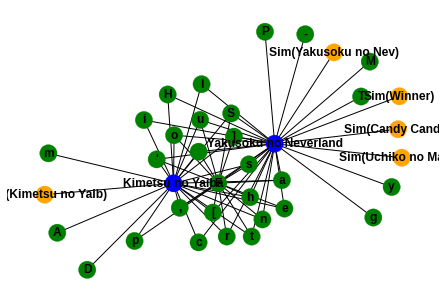

In [ ]:
list_in=["Kimetsu no Yaiba","Yakusoku no Neverland"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [ ]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="ANIME":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

In [ ]:
result1 = get_recommendation("Kimetsu no Yaiba")
result2 = get_recommendation("Yakusoku no Neverland")

print("*"*40+"\n Recommendation for 'Kimetsu no Yaiba'\n"+"*"*40)
print(result1.head())
print("*"*40+"\n Recommendation for 'Yakusoku no Neverland'\n"+"*"*40)
print(result2.head())

****************************************
 Recommendation for 'Kimetsu no Yaiba'
****************************************
Kimetsu no Yaiba Movie: Mugen Ressha-hen                               3.023834
Devilman: Yochou Sirene-hen                                            2.787652
Gintama.: Shirogane no Tamashii-hen                                    2.772980
Honoo no Mirage: Minagiwa no Hangyakusha                               2.589539
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!    2.589539
dtype: float64
****************************************
 Recommendation for 'Yakusoku no Neverland'
****************************************
Yakusoku no Neverland 2nd Season    3.371627
B: The Beginning 2                  3.124615
Paprika                             2.960784
AD Police                           2.937333
Shinsekai yori                      2.864051
dtype: float64


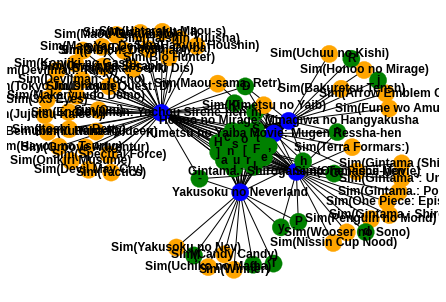

In [ ]:
reco=list(result.index[:4].values)
reco.extend(["Yakusoku no Neverland"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)